Data from [single-cell time-lapse of mouse prenatal development from gastrula to birth](https://doi.org/10.1038/s41586-024-07069-w)

In [2865]:
import anndata
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from CoPhaser import utils
from CoPhaser.trainer import Trainer
from CoPhaser.loss import Loss
from CoPhaser import plotting
from CoPhaser.model import CoPhaser
from CoPhaser.model import VAEModelLoader
import numpy as np

In [2866]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2867]:
DATA_FOLDER = "../../../data/"
adata = anndata.read_h5ad(
    f"{DATA_FOLDER}/somite/mesodermal_progenitors_Tbx6p_names_mapped_2.h5ad"
)

In [2868]:
adata_total = adata.copy()
adata = adata[adata.obs["cycling"]].copy()

In [2869]:
adata.layers["total"] = adata.X.copy()

In [2870]:
g = utils.get_variable_genes(adata, n_variable_genes=1000, layer="total")

In [ ]:
import pandas as pd

df_cycling = pd.read_csv("somite_genes_amplitude_phase.csv", index_col=0)
df_cycling = df_cycling[df_cycling.index.isin(adata.var_names)]
cycling_genes = df_cycling.index.tolist()

In [2875]:
model = CoPhaser(
    cycling_genes,
    g,
    n_latent=10,
    n_harm=3,
    use_mu_z_encoder=True,
    lambda_range=2,
    z_range=20,
)  # phase_shifted_genes=["Lef1","Dact1","Axin2","Nkd1"])

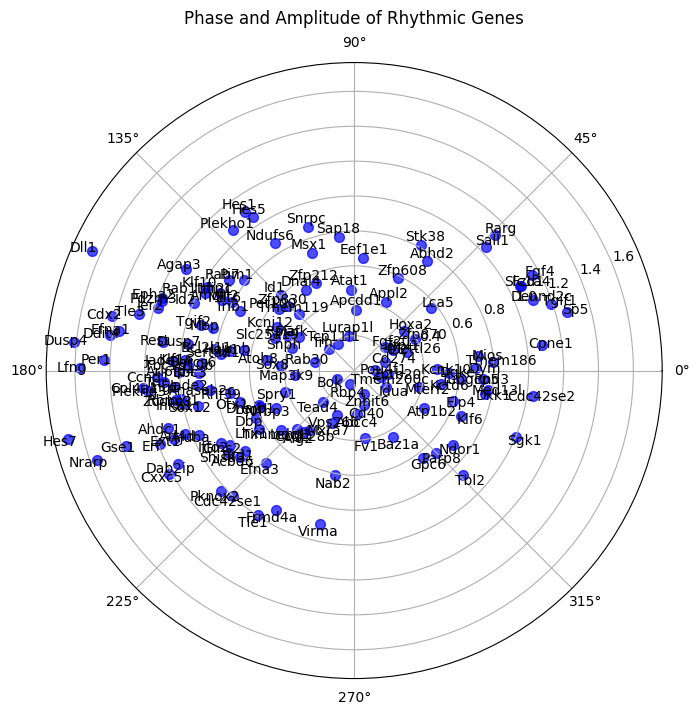

Epoch 1/200, elbo_loss: 3252.3324, kl_div_f: 4.6777, kl_div_z: 15.4839, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -1.9920, entropy_loss: -298.7970, radial_variance: 0.9399, radius: 9.2457, L1_mu_z: 0.0000, MI_loss: 0.0000, total_loss: 2963.7209
Epoch 2/200, elbo_loss: 2811.2555, kl_div_f: 4.6238, kl_div_z: 32.4444, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -1.5514, entropy_loss: -232.7056, radial_variance: 2.3703, radius: 16.8323, L1_mu_z: 0.0000, MI_loss: 0.0000, total_loss: 2597.7546
Epoch 3/200, elbo_loss: 2728.0850, kl_div_f: 4.5670, kl_div_z: 36.1810, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -2.2532, entropy_loss: -337.9788, radial_variance: 6.0608, radius: 13.9172, L1_mu_z: 0.0000, MI_loss: 0.0001, total_loss: 2410.0975
Epoch 4/200, elbo_loss: 2685.3385, kl_div_f: 4.5020, kl_div_z: 32.9277, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -2.4078, 

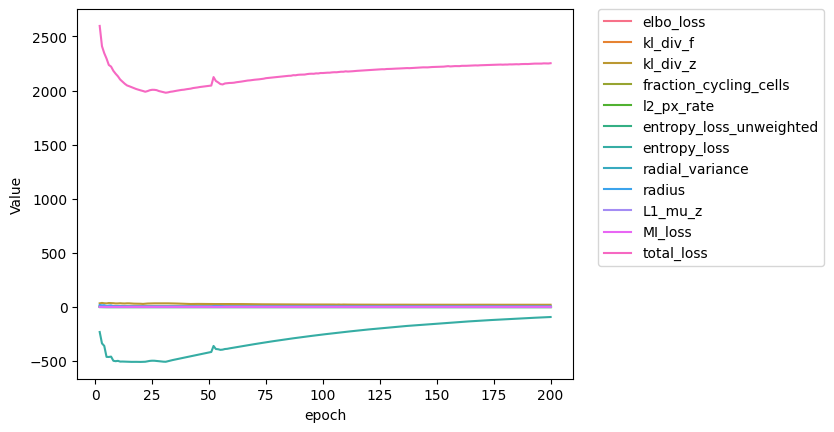

In [2876]:
model.load_anndata(adata, layer_to_use="total")
VAEModelLoader.define_decoder_prior(amp_phase_prior=df_cycling.copy(), model=model)
model.plot_fourier_coefficients()
trainer = Trainer(
    model,
    Loss.compute_loss,
    noise_model="NB",
    L2_Z_decoder_loss_weight=0,
    entropy_weight_factor=150,
    beta_kl_f=0.1,
    MI_weight=100,
    closed_circle_weight=15,
    cycling_status_prior=1,
    rhythmic_likelihood_weight=10,
    non_rhythmic_likelihood_weight=4,
    unfreeze_epoch_layer=[(20, "rhythmic_decoder")],
    MI_detach="none",
)
trainer.train_model(n_epochs=200, lr=1e-2, device="cuda", batch_size=8192)  # 8192,

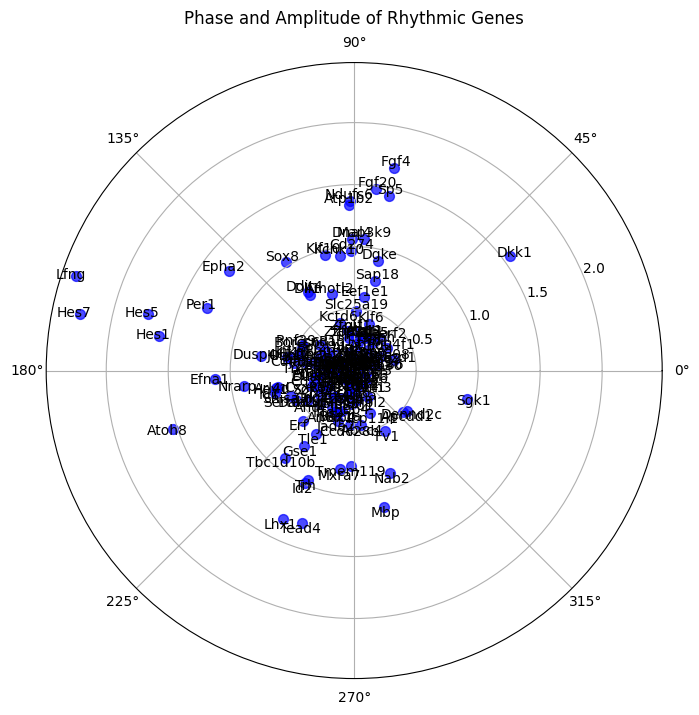

In [2877]:
model.plot_fourier_coefficients()

In [2878]:
["Axin2", "Dact1", "Nkd1", "Lef1"]

['Axin2', 'Dact1', 'Nkd1', 'Lef1']

In [2879]:
adata_total.obs["cycling"].mean()

0.5540367741082058

In [2880]:
"""adata = adata_total[
    adata_total.obs["leiden_label"].isin(
        ["5", "6", "1", "0", "2", "13", "12"]  # + ["3", "7"]
    )
]
model.load_anndata(adata=adata, layer_to_use="total")
model.prepare_context_training(adata, "total")
trainer.retrain_model(n_epochs=100, lr=1e-2, device="cuda", batch_size=2048)"""

'adata = adata_total[\n    adata_total.obs["leiden_label"].isin(\n        ["5", "6", "1", "0", "2", "13", "12"]  # + ["3", "7"]\n    )\n]\nmodel.load_anndata(adata=adata, layer_to_use="total")\nmodel.prepare_context_training(adata, "total")\ntrainer.retrain_model(n_epochs=100, lr=1e-2, device="cuda", batch_size=2048)'

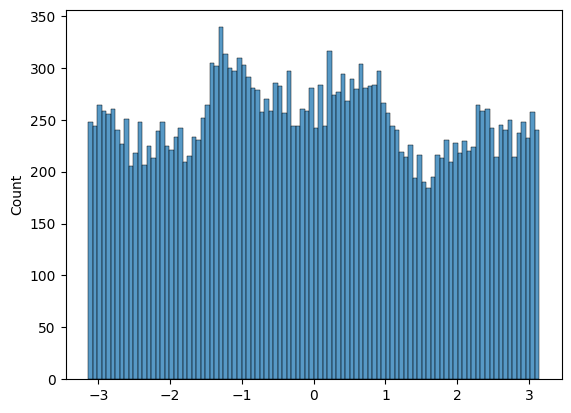

In [2881]:
# Get the infered theta values
model.to("cpu")
generative_outputs, space_outputs = model.get_outputs()
thetas = space_outputs["theta"].detach().numpy()
sns.histplot(x=thetas, bins=100, common_norm=False)
adata.obs["inferred_theta"] = thetas

<Axes: >

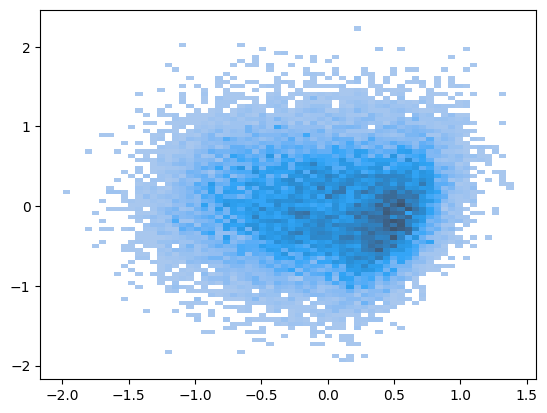

In [2882]:
cells_projected = space_outputs["x_projected"].detach().numpy()
sns.histplot(x=cells_projected[:, 0], y=cells_projected[:, 1])

<Axes: ylabel='Density'>

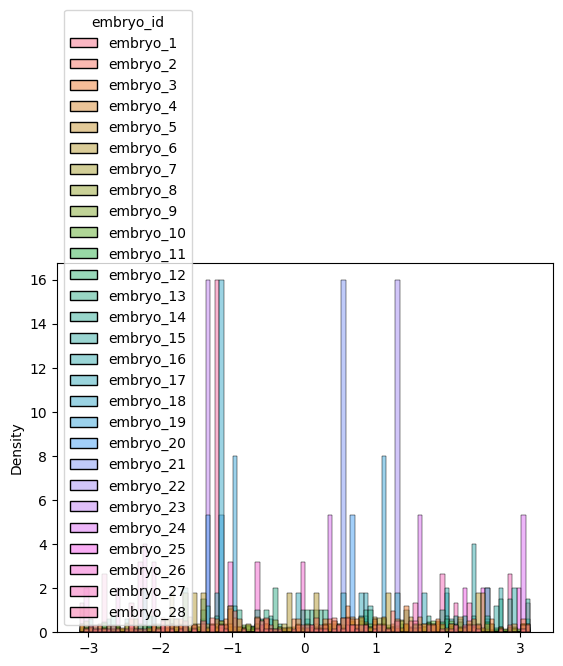

In [2883]:
i_tb = adata.obs["is_TB"].values
sns.histplot(
    x=thetas[i_tb],
    bins=100,
    hue=adata[i_tb].obs["embryo_id"],
    stat="density",
    common_norm=False,
)

In [2884]:
space_outputs["f"]

tensor([[ 0.4632,  0.8863, -0.5710,  0.8210, -0.9921, -0.1258],
        [-0.5447,  0.8386, -0.4066, -0.9136,  0.9877,  0.1566],
        [-0.5871, -0.8095, -0.3106,  0.9506,  0.9518, -0.3067],
        ...,
        [-0.6779, -0.7351, -0.0808,  0.9967,  0.7875, -0.6163],
        [ 0.8187,  0.5742,  0.3407,  0.9402, -0.2609,  0.9654],
        [-0.6738,  0.7389, -0.0921, -0.9958,  0.7978,  0.6029]])

In [2885]:
def add_theta(df, theta):
    df["inferred_theta"] = theta
    return df


df_mean = pd.DataFrame(
    generative_outputs["px_rate"].detach().numpy(), columns=model.context_genes
)
df_mean = add_theta(df_mean, thetas)
df_rhythmic = pd.DataFrame(
    generative_outputs["F"].detach().numpy(), columns=model.context_genes
)
# df_rhythmic = pd.DataFrame(generative_outputs["rhythmic_term"].detach().numpy(), columns=model.context_genes)
df_rhythmic = add_theta(df_rhythmic, thetas)
df_z = pd.DataFrame(
    generative_outputs["Z"].detach().numpy(), columns=model.context_genes
)
df_z = add_theta(df_z, thetas)

In [2886]:
generative_outputs["F"]

tensor([[-0.2026,  0.1919,  0.1012,  ...,  0.0344, -0.0540, -0.2082],
        [-0.3130,  0.3519, -0.5747,  ..., -0.1528,  0.0378, -0.0470],
        [ 0.2349,  0.1622,  0.1861,  ..., -0.0779,  0.0538,  0.2500],
        ...,
        [ 0.2916,  0.0560,  0.2344,  ..., -0.1199,  0.0678,  0.2897],
        [-0.1568, -0.0766,  0.6032,  ...,  0.1502, -0.0443, -0.3359],
        [-0.3576,  0.3814, -0.6534,  ..., -0.2063,  0.0667,  0.0183]])

In [2887]:
library_size = adata.layers["total"].sum(axis=1)  # .A1

<Axes: ylabel='Count'>

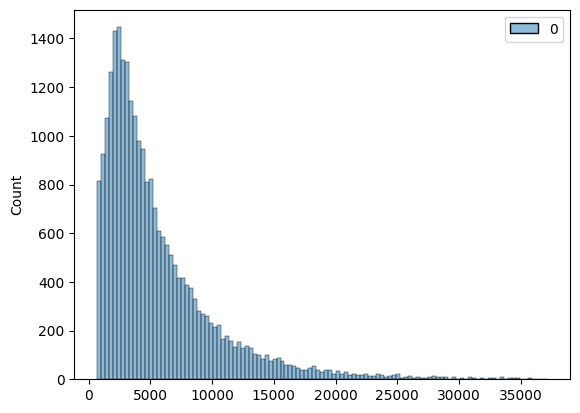

In [2892]:
sns.histplot(library_size)

In [2893]:
coeffs = model.rhythmic_decoder.fourier_coefficients.weight.detach().numpy()

# Assuming coeffs shape = (n_genes, 2) -> [:,0] = cosine (a), [:,1] = sine (b)
a = coeffs[:, 0]
b = coeffs[:, 1]

# Compute amplitude and phase
amplitude = np.sqrt(a**2 + b**2)
phase = np.arctan2(b, a)  # radians

# Create DataFrame
df = pd.DataFrame({"gene": model.context_genes, "amplitude": amplitude, "phase": phase})
df = df[df["gene"].isin(model.rhythmic_gene_names)]
df

,gene,amplitude,phase
17,Erf,0.581806,-2.367907
21,Cdc42se1,0.260859,-2.306334
26,Klf16,0.474836,2.862370
39,Kcnj12,0.093587,2.589398
40,Zbtb20,0.086095,1.168810
...,...,...,...
1131,Sgk1,0.941094,-0.248776
1139,Nrarp,0.898238,-3.001651
1150,Abhd2,0.195696,0.975247
1152,Rest,0.233529,-2.621506


In [2894]:
space_outputs["b_z"].mean()

tensor(1.)

/home/maxine/Documents/paychere/CoPhaser/src/CoPhaser/plotting.py:548: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend(loc="upper left", bbox_to_anchor=(1, 1))


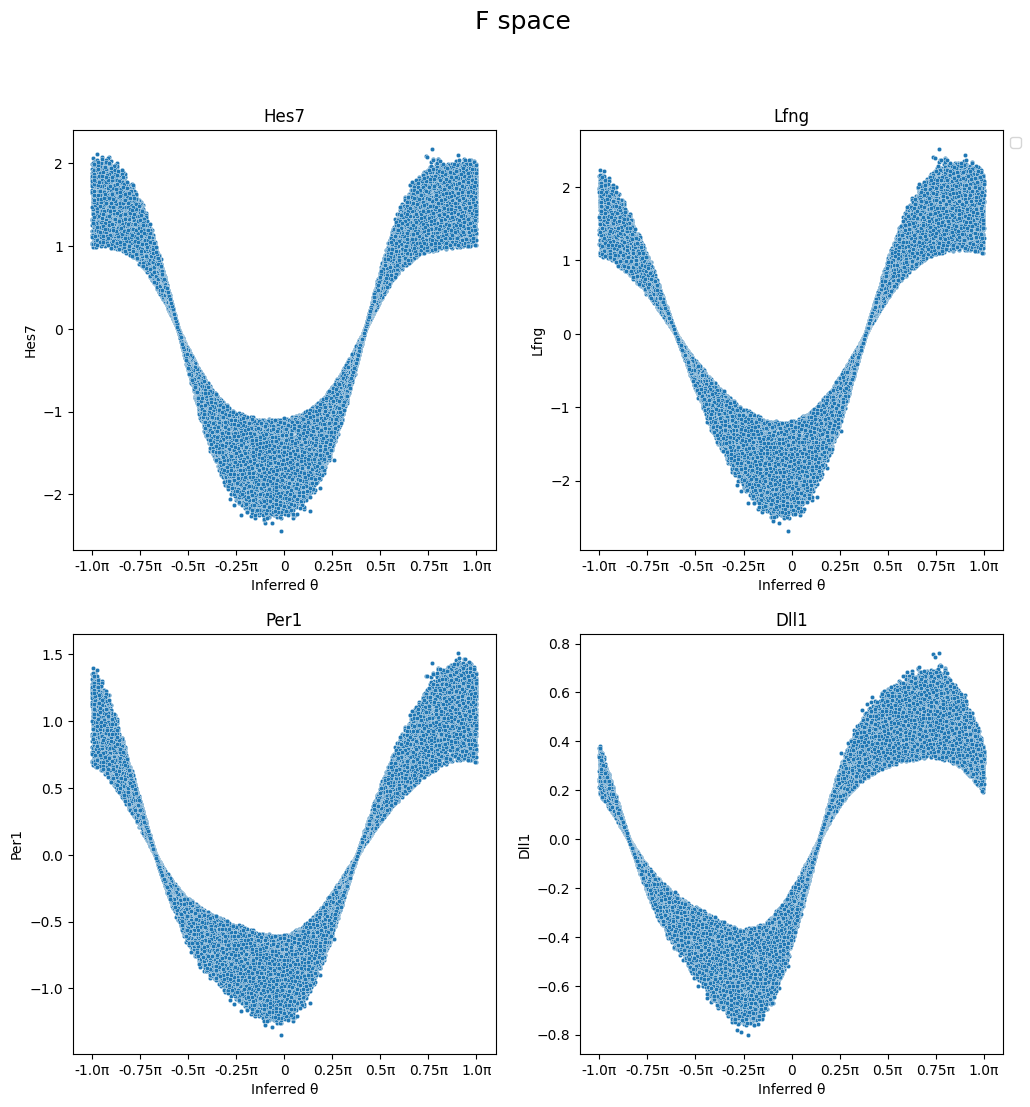

In [2896]:
genes = ["Hes7", "Lfng", "Per1", "Dll1"]
plotting.plot_model_decoded_space(
    df_rhythmic, gene_to_upper=False, title="F space", genes=genes
)

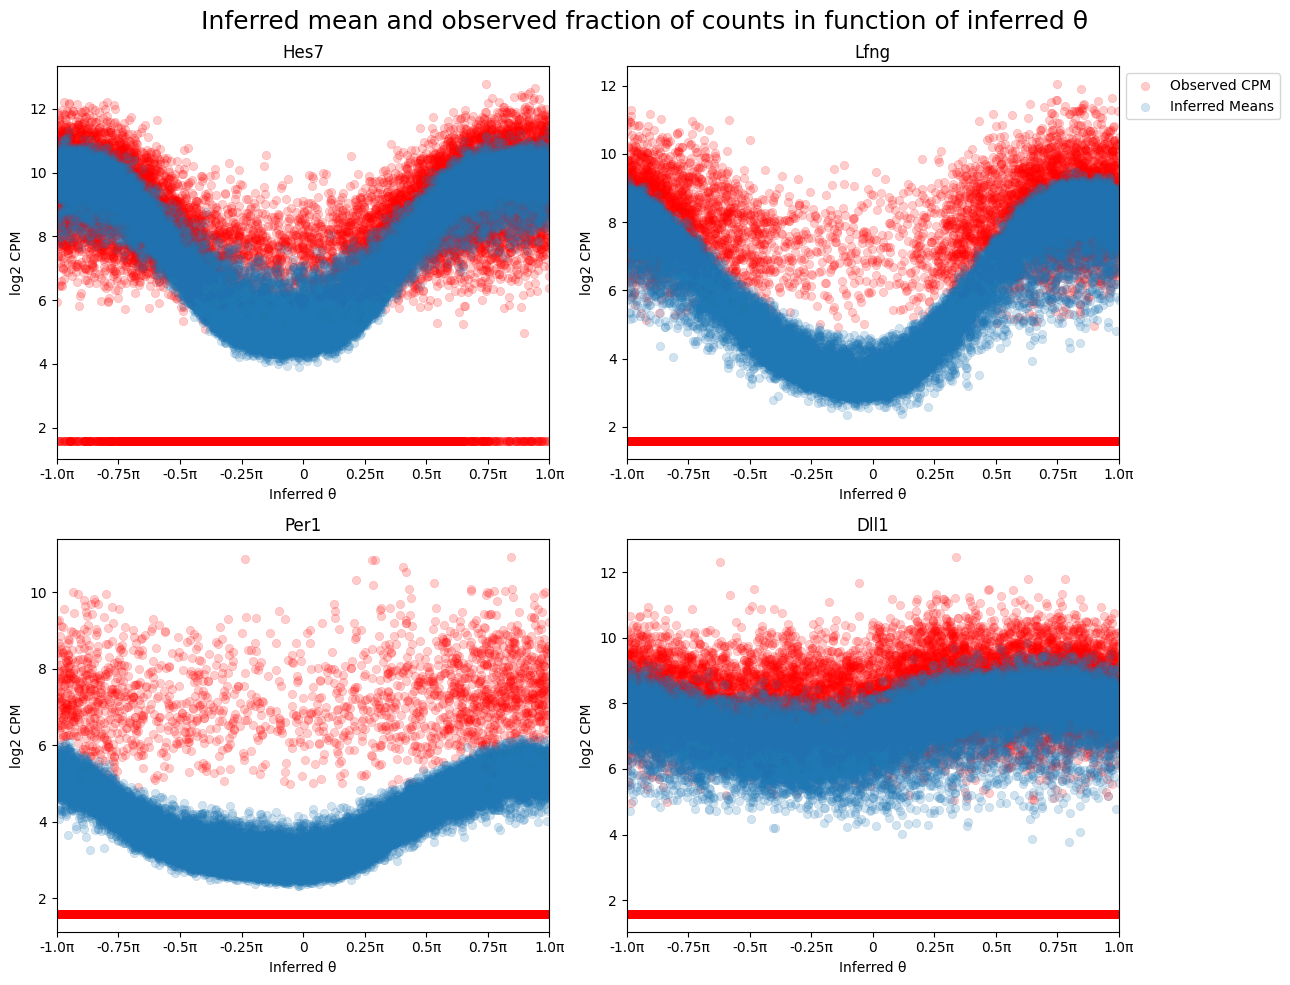

In [2898]:
plotting.plot_gene_profile(df_mean, adata, genes, "total", 2, False, library_size.A1)

In [2903]:
adata.obs["keep"] = True

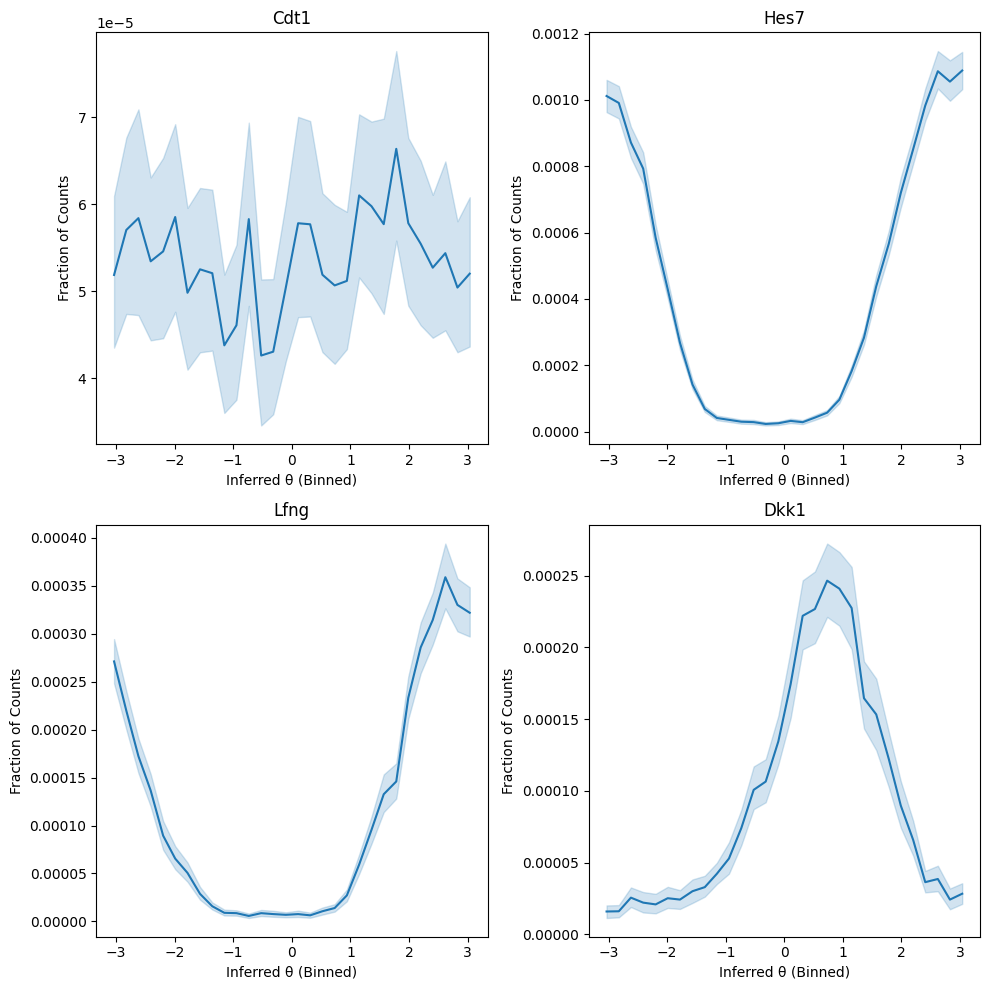

In [2904]:
def plot_gene_profile(
    adata,
    genes=genes,
    layer_to_use="total",
    ncols=2,
    gene_to_upper=False,
    library_size=None,
    cell_type_field="cell_type",
    n_bins=30,  # Number of bins for inferred θ
):
    # Determine grid size
    nrows = np.ceil(len(genes) / ncols).astype(int)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))
    axs = axs.flatten()

    # Convert gene names to uppercase if needed
    if gene_to_upper:
        genes = [gene.upper() for gene in genes]

    # Calculate library size if not provided
    if library_size is None:
        library_size = adata.layers[layer_to_use].sum(axis=1).A1

    # Extract inferred θ and batch information
    inferred_theta = adata.obs["inferred_theta"].values
    cell_type = adata.obs[cell_type_field].values

    for i, gene in enumerate(genes):
        if i >= len(axs):
            break  # Skip extra axes

        # Extract expression data for the gene
        expression = (
            adata[:, gene].layers[layer_to_use].toarray().flatten() / library_size
        )

        # Create a DataFrame for plotting
        df = pd.DataFrame(
            {
                "inferred_theta": inferred_theta,
                "expression": expression,
                cell_type_field: cell_type,
            }
        )

        # Bin inferred θ into `n_bins` bins
        df["theta_bin"] = pd.cut(df["inferred_theta"], bins=n_bins, labels=False)
        df["binned_theta"] = df.groupby("theta_bin")["inferred_theta"].transform("mean")

        # Compute the mean expression in each bin for each cell_type
        bin_means = (
            df.groupby(["theta_bin", cell_type_field])["expression"].mean().unstack()
        )

        # Calculate the ratio of cell_type means for each bin
        # avg_ratio = ((bin_means.iloc[:,1] - bin_means.iloc[:,0]) / (bin_means.iloc[:,1] + bin_means.iloc[:,0])).mean() * 100# Assuming cell_type labels are 0 and 1
        # print(f"Gene: {gene}, Average Ratio (cell_type 1 / cell_type 0): {avg_ratio:.3f}")

        # Plot smoothed gene profile using sns.lineplot
        sns.lineplot(
            data=df,
            x="binned_theta",
            y="expression",
            hue=cell_type_field,
            ax=axs[i],
            legend=False,
        )

        # Set plot labels and title
        axs[i].set(
            xlabel="Inferred θ (Binned)",
            ylabel="Fraction of Counts",
            title=f"{gene}",
        )

    # Adjust layout
    plt.tight_layout()
    plt.show()


plot_gene_profile(
    adata[space_outputs["b_z"].detach().numpy() > 0.5],
    layer_to_use="total",
    cell_type_field="keep",
    genes=["Cdt1", "Hes7", "Lfng", "Dkk1"],
)
# ["TBXT", "CDX2", "RIPPLY2","MESP2"]

In [2905]:
df_fourier = pd.DataFrame(
    model.rhythmic_decoder.fourier_coefficients.weight.detach().numpy(),
    index=model.context_genes,
)

In [2907]:
df_fourier["amplitude"] = df_fourier.loc[:, 0] ** 2 + df_fourier.loc[:, 1] ** 2

In [2908]:
df_fourier["means"] = np.exp(model.mean_genes)

In [2910]:
df_fourier["score"] = df_fourier["means"] * df_fourier["amplitude"] ** 2

In [2911]:
df_fourier.sort_values(by="score", ascending=False).head(20)

,0,1,2,3,4,5,amplitude,means,score
Hes7,-2.210938,0.454532,-0.099230,0.057933,0.160598,-0.124328,5.094847,0.000389,0.010093
Lfng,-2.240992,0.760094,-0.121960,-0.073791,0.003327,-0.079778,5.599785,0.000098,0.003059
Dkk1,1.253425,0.922983,-0.091782,0.112516,0.040126,-0.040180,2.422971,0.000079,0.000466
Fgf4,0.323028,1.635626,-0.244528,-0.032343,0.014387,0.063968,2.779621,0.000024,0.000187
Sp5,0.282666,1.410339,-0.095802,0.117899,-0.036018,0.075481,2.068957,0.000035,0.000148
Hes1,-1.576751,0.278995,0.077450,-0.026632,0.013292,0.043518,2.563981,0.000020,0.000133
Efna1,-1.119520,-0.067648,-0.043485,-0.017474,0.003223,-0.001716,1.257901,0.000061,0.000097
Hes5,-1.661083,0.456364,0.371518,-0.125521,-0.038372,-0.157501,2.967465,0.000009,0.000082
Gse1,-0.407079,-0.611891,-0.051629,-0.007085,-0.048583,0.011602,0.540124,0.000218,0.000064
Per1,-1.191070,0.507212,0.072450,-0.087737,-0.065933,-0.055915,1.675911,0.000017,0.000048


<Axes: xlabel='posterior_anterior_axis', ylabel='inferred_theta'>

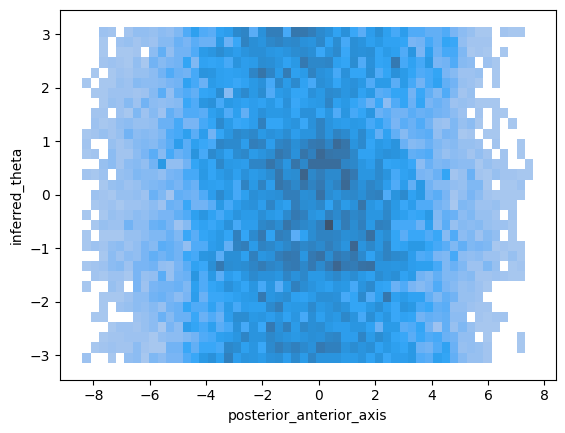

In [2922]:
sns.histplot(adata.obs, y="inferred_theta", x="posterior_anterior_axis")

In [2925]:
adata.obs["Hes7"] = adata.layers["total"][:, adata.var_names.get_loc("Hes7")].toarray()

In [2928]:
# PCA of the z space
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced = pca.fit_transform(space_outputs["z"].detach().numpy())
# find dimension that correlates with post_ant
correlations = np.corrcoef(reduced.T, adata.obs["posterior_anterior_axis"], rowvar=1)
# take the max dimension abs correlation
dim = np.argmax(np.abs(correlations[:-1, -1]))
print(correlations[dim, -1])
# if correlation is negative, flip the sign
adata.obs["post_ant_model"] = reduced[:, dim] * (1 if correlations[dim, -1] > 0 else -1)

0.8692965709361407


<Axes: xlabel='posterior_anterior_axis', ylabel='Count'>

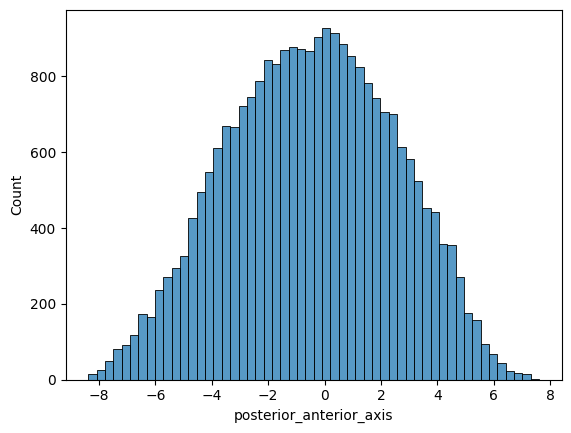

In [2930]:
sns.histplot(adata.obs["posterior_anterior_axis"])

In [2933]:
import umap

reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(space_outputs["z"].detach().numpy())

/home/maxine/miniconda3/envs/CoPhaser_Env/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Axes: >

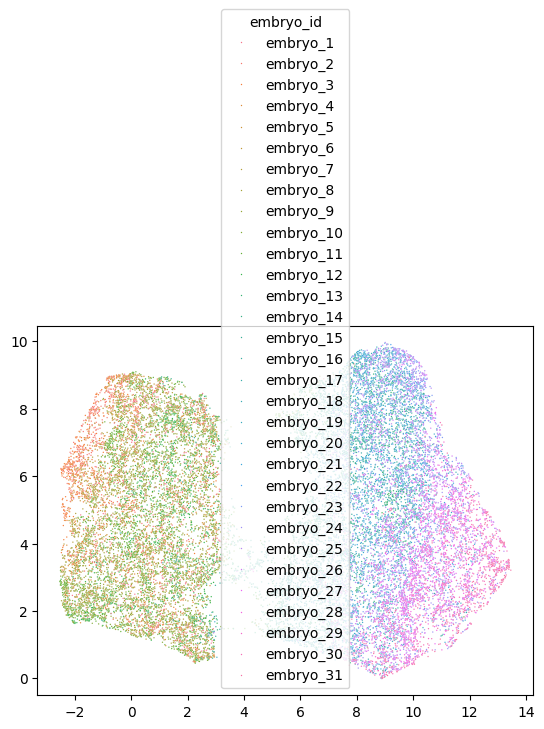

In [2934]:
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=adata.obs["embryo_id"], s=1)

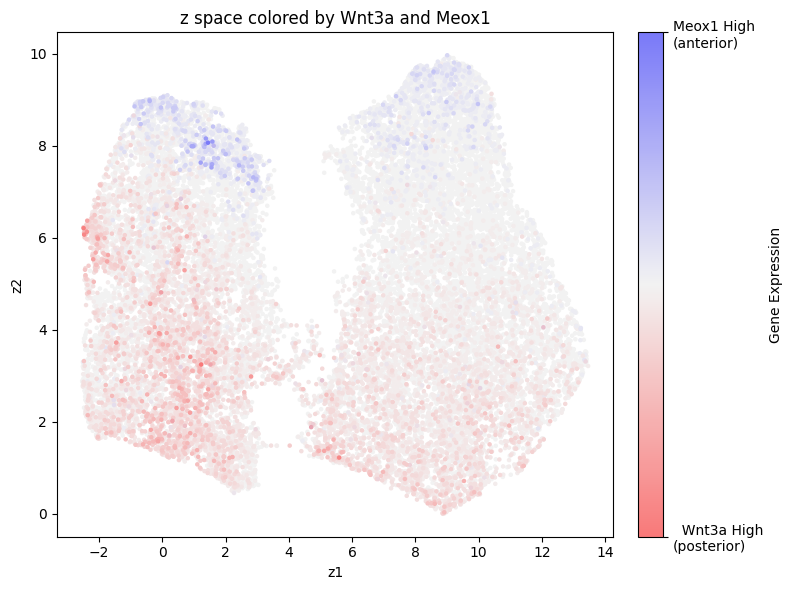

In [2935]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


# Your existing normalization and color calculation
def get_color(Wnt3a_norm, Meox1_norm, base=0.95):
    base_c = base * (1 - (Wnt3a_norm / 2 + Meox1_norm / 2))
    R = np.clip(base_c + 0.5 * Wnt3a_norm, 0, 1)
    B = np.clip(base_c + 0.5 * Meox1_norm, 0, 1)
    G = np.full_like(R, base_c)
    return np.stack([R, G, B], axis=-1)


# Get gene expressions
Wnt3a_expr = (
    adata[:, "Wnt3a"].X.toarray().flatten()
    if hasattr(adata[:, "Wnt3a"].X, "toarray")
    else adata[:, "Wnt3a"].X.flatten()
)
Meox1_expr = (
    adata[:, "Meox1"].X.toarray().flatten()
    if hasattr(adata[:, "Meox1"].X, "toarray")
    else adata[:, "Meox1"].X.flatten()
)

# Normalize expression
Wnt3a_norm = (Wnt3a_expr - Wnt3a_expr.min()) / (Wnt3a_expr.max() - Wnt3a_expr.min())
Meox1_norm = (Meox1_expr - Meox1_expr.min()) / (Meox1_expr.max() - Meox1_expr.min())

# Compute colors for points
base = 0.95
base_c = base * (1 - (Wnt3a_norm / 2 + Meox1_norm / 2))
R = np.clip(base_c + 0.5 * Wnt3a_norm, 0, 1)
B = np.clip(base_c + 0.5 * Meox1_norm, 0, 1)
G = np.full_like(R, base_c)
colors = np.stack([R, G, B], axis=1)

# Sorting for plotting
sort_index = np.argsort(Wnt3a_norm + Meox1_norm)
z_sorted = embedding[sort_index]
colors_sorted = colors[sort_index]

# Plot scatter
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(z_sorted[:, 0], z_sorted[:, 1], c=colors_sorted, s=5)
ax.set_xlabel("z1")
ax.set_ylabel("z2")
ax.set_title("z space colored by Wnt3a and Meox1")
ax.grid(False)

# Now create the colorbar:

# Sample points from Wnt3a=1, Meox1=0 to Wnt3a=0, Meox1=1 (linear interpolation)
n_steps = 256
Wnt3a_line = np.concatenate([np.linspace(1, 0, n_steps // 2), np.zeros(n_steps // 2)])
Meox1_line = np.concatenate([np.zeros(n_steps // 2), np.linspace(0, 1, n_steps // 2)])

# Compute colors along this line using your color function
colorbar_colors = get_color(Wnt3a_line, Meox1_line, base=0.95)

# Create a ListedColormap from these colors
cmap = mpl.colors.ListedColormap(colorbar_colors)

# Create a ScalarMappable for the colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=0, vmax=1))
sm.set_array([])

# Add vertical colorbar
cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04, orientation="vertical")

# Set ticks at 0 (Wnt3a high) and 1 (Meox1 high)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["  Wnt3a High\n(posterior)", "Meox1 High\n(anterior)"])
cbar.set_label("Gene Expression")
plt.tight_layout()

In [ ]:
# to_save = {
#     "projected_z": embedding,
#     "df_rhythmic": df_rhythmic,
#     "thetas": thetas,
#     "lambda": generative_outputs["lambda"].detach().numpy(),
#     "f_coeff": model.rhythmic_decoder.fourier_coefficients.weight.detach().numpy(),
#     "gene_names": model.rhythmic_gene_names,
# }
# import pickle

# with open("data/somite_res.pkl", "wb") as f:
#     pickle.dump(to_save, f)

In [2939]:
import pickle

# load results cell cycle
with open("data/chengxiang_cell_cycle_results.pkl", "rb") as f:
    cell_cycle_results = pickle.load(f)

<Axes: >

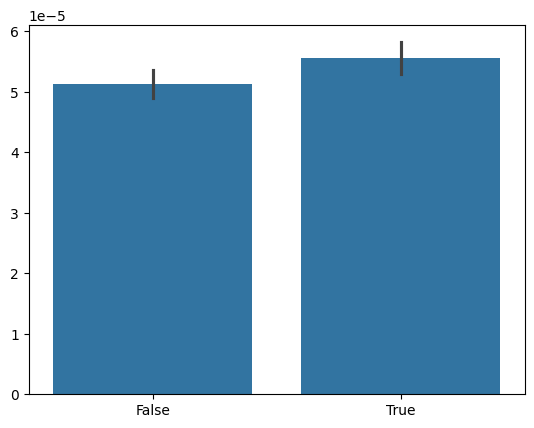

In [2948]:
# plot hes 7 for cells with cell cycle phase between -2 and -1
i_leiden = adata_total.obs["cycling"]
i_cycle = (cell_cycle_results["inferred_theta"] > 0.5) & (
    cell_cycle_results["inferred_theta"] < 1
)
i_cycle = thetas > 0
sns.barplot(
    x=i_cycle,  # [i_leiden],
    y=(
        adata[:, "Cdt1"].layers["total"].toarray().flatten() / library_size.flatten()
    ).A1,
)

In [2949]:
# plot hes 7 for cells with cell cycle phase between -2 and -1
i_cycle = (cell_cycle_results["inferred_theta"] > 1.5) & (
    cell_cycle_results["inferred_theta"] < 2.5
)
# import circmean
from scipy.stats import circmean

circmean(thetas[i_cycle[i_leiden]], high=np.pi, low=-np.pi)

-0.7903842329978943

In [2950]:
thetas[i_cycle[i_leiden]].shape

(3109,)

In [2951]:
def circcorr(a, b):
    """Circular correlation between two angle arrays a and b (in radians)."""
    assert len(a) == len(b), "Input arrays must have the same length."
    n = len(a)
    sin_a = np.sin(a - circmean(a, high=np.pi, low=-np.pi))
    sin_b = np.sin(b - circmean(b, high=np.pi, low=-np.pi))
    num = np.sum(sin_a * sin_b)
    den = np.sqrt(np.sum(sin_a**2) * np.sum(sin_b**2))
    return num / den


circcorr(a=thetas, b=cell_cycle_results["inferred_theta"][i_leiden])

0.014639861

In [2952]:
circmean(thetas[~i_cycle[i_leiden]], high=np.pi, low=-np.pi)

-0.4195244014263153

In [2953]:
is_in_anterior = (
    adata.obs["posterior_anterior_axis"] > adata.obs["posterior_anterior_axis"].median()
)
circcorr(
    a=thetas[is_in_anterior],
    b=cell_cycle_results["inferred_theta"][is_in_anterior & i_leiden],
)

0.0027658977

In [2954]:
circcorr(
    a=thetas[~is_in_anterior],
    b=cell_cycle_results["inferred_theta"][~is_in_anterior & i_leiden],
)

0.009617859

<PolarAxes: ylabel='Density'>

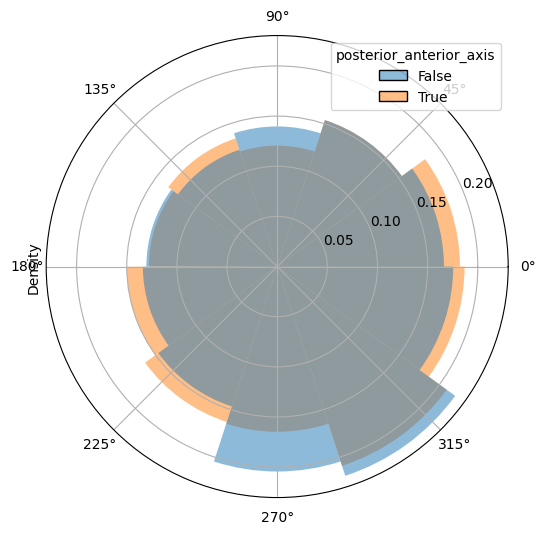

In [2955]:
# plot phase ditributions

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={"projection": "polar"})
sns.histplot(
    x=thetas[i_cycle[i_leiden]],
    bins=10,
    alpha=0.5,
    hue=is_in_anterior[i_cycle[i_leiden]],
    stat="density",
    common_norm=False,
    ax=ax,
)

<PolarAxes: ylabel='Density'>

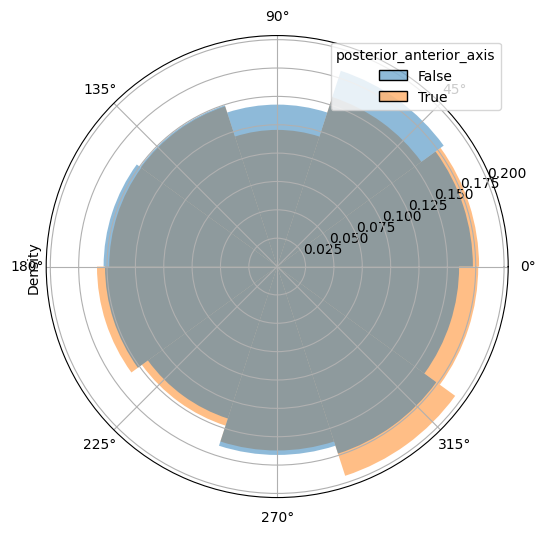

In [2956]:
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={"projection": "polar"})
sns.histplot(
    x=thetas,
    bins=10,
    alpha=0.5,
    hue=is_in_anterior,
    stat="density",
    common_norm=False,
    ax=ax,
)

<PolarAxes: ylabel='Density'>

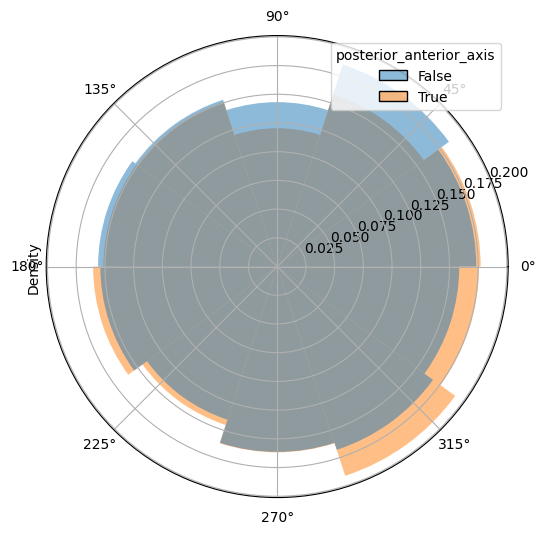

In [2957]:
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={"projection": "polar"})
sns.histplot(
    x=thetas[~i_cycle[i_leiden]],
    bins=10,
    alpha=0.5,
    hue=is_in_anterior[~i_cycle[i_leiden]],
    stat="density",
    common_norm=False,
    ax=ax,
)